In [52]:
#Import Required Libraries

%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_curve, recall_score, roc_auc_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import seaborn as sns
import numpy as np
import pandas as pd
import itertools
import scikitplot as skplt

# Data loading and transformation

In [2]:
#Load dataset wdbc.data
wdbc_cancer = pd.read_csv("HW1/wdbc.data", header=None)

'#Encode B and M to 0 and 1
conv = {'B':0, 'M':1}
wdbc_cancer[1] = wdbc_cancer[1].map(conv)'

#Create column names or feature names for all the variables
wdbc_cancer.columns = ['id','diagnosis','mean_radius','mean_texture','mean_perimeter','mean_area','mean_smoothness',
                       'mean_compactness','mean_concavity','mean_concave_points','mean_symmetry','mean_fractal_dimension',
                       'radius_error','texture_error','perimeter_error','area_error','smoothness_error','compactness_error',
                       'concavity_error','concave_points_error', 'symmetry_error', 'fractal_dimension_error','worst_radius',
                       'worst_texture','worst_perimeter', 'worst_area', 'worst_smoothness','worst_compactness', 
                       'worst_concavity','worst_concave_points', 'worst_symmetry', 'worst_fractal_dimension']

#Drop id column as it is not required 
wdbc_cancer.drop('id',axis=1,inplace=True)

#Unique values or categories for diagnosis
print(wdbc_cancer.diagnosis.unique())

# Malignant cases
malignant = len(wdbc_cancer[wdbc_cancer['diagnosis']==1])
#Benign cases
benign = len(wdbc_cancer[wdbc_cancer['diagnosis']==0])

print("There are {}".format(malignant)+" malignant cases.")
print("There are {}".format(benign)+" benign cases. \n")


#Separate features and target columns
#Features
features = list(wdbc_cancer.columns[1:30])

#Target 
target = wdbc_cancer.columns[0]

#Separate the data into feature data (X) and target data (y)
X = wdbc_cancer[features] 
y = wdbc_cancer[target]

[1 0]
There are 212 malignant cases.
There are 357 benign cases. 



In [3]:
#Creating arrays to store the values of all models to compare different models
accuracy_all_models = []
cross_val_score_all_models = []
precision_all = []
recall_all = []
f_measure_all = []

# Model Fitting and Evaluation

In [4]:
#Split the dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123, test_size = 0.25)

#Normalise the train dataset 
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std  = std_scale.transform(X_test)

In [5]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Decision Tree

In [6]:
# Set the parameters by cross-validation
params = {'max_depth': np.arange(3, 10), 'min_samples_split' : range(10,100,20)}
model = DecisionTreeClassifier(random_state=1234, class_weight= "balanced")
grid = GridSearchCV(model, param_grid=params, cv=10, scoring="accuracy", n_jobs=-1)

#Learning
grid.fit(X_train_std, y_train)

#Evaluate
print (grid.best_score_)
print (grid.best_params_)
#print (grid.best_estimator_)

model = grid.best_estimator_
model.fit(X_train_std, y_train)
y_pred = model.predict(X_test_std)

print("Prediction Accuracy: \n",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9342723004694836
{'max_depth': 5, 'min_samples_split': 10}
Prediction Accuracy: 
 0.8951048951048951
             precision    recall  f1-score   support

          0       0.96      0.87      0.91        90
          1       0.81      0.94      0.87        53

avg / total       0.90      0.90      0.90       143



Normalized confusion matrix


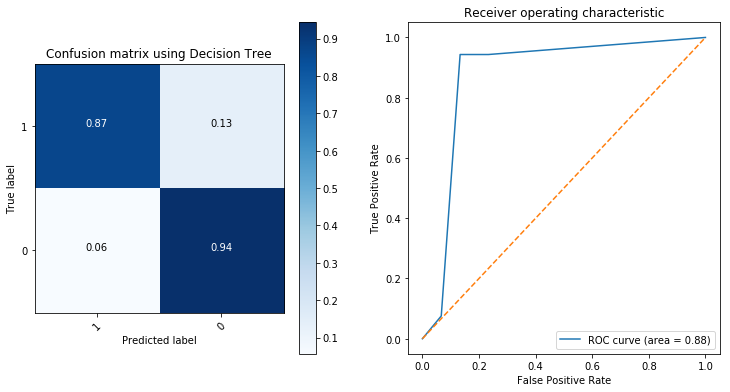

In [7]:
#Confusion Matrix
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,5))
plt.subplot(121)
clas= np.array(wdbc_cancer.diagnosis.unique())
plot_confusion_matrix(conf, classes= clas, normalize=True, title='Confusion matrix using Decision Tree')

## Predict scores
y_score_dt = model.predict_proba(X_test_std)[:,1]

#Plot ROC 
# ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_score_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.subplots_adjust(wspace=0.2)
plt.subplot(122)
plt.plot(fpr_dt, tpr_dt, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

prec_recall_results = precision_recall_fscore_support(y_test, y_pred, average='weighted')
#Append to compare different models
accuracy_all_models.append(accuracy_score(y_test, y_pred))
precision_all.append(prec_recall_results[0])
recall_all.append(prec_recall_results[1])
f_measure_all.append(prec_recall_results[2])

# Logistic Regression

In [8]:
# Set the parameters by cross-validation

params = {"C": [0.1, 1, 10, 100],
         "penalty" : ['l1','l2']}
model = LogisticRegression(random_state=1234, class_weight= "balanced")
grid = GridSearchCV(model, param_grid=params, cv=10, scoring="accuracy", n_jobs=-1)

#Learning
grid.fit(X_train_std, y_train)

#Evaluate
print (grid.best_score_)
print (grid.best_params_)
#print (grid.best_estimator_)

model = grid.best_estimator_
model.fit(X_train_std, y_train)
y_pred = model.predict(X_test_std)

print("Prediction Accuracy: \n",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9835680751173709
{'C': 0.1, 'penalty': 'l2'}
Prediction Accuracy: 
 0.958041958041958
             precision    recall  f1-score   support

          0       0.98      0.96      0.97        90
          1       0.93      0.96      0.94        53

avg / total       0.96      0.96      0.96       143



Normalized confusion matrix


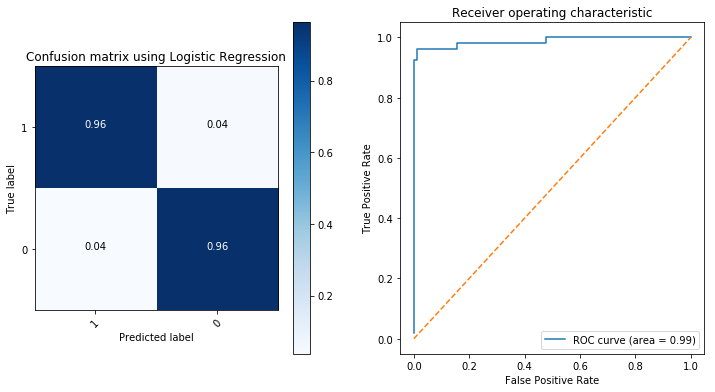

In [9]:
#Confusion Matrix
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,5))
plt.subplot(121)
clas= np.array(wdbc_cancer.diagnosis.unique())
plot_confusion_matrix(conf, classes= clas, normalize=True, title='Confusion matrix using Logistic Regression')

## Predict scores
y_score_lr = model.predict_proba(X_test_std)[:,1]
fpr_ll, tpr_ll, _ = roc_curve(y_test, y_score_lr)
roc_auc_ll = auc(fpr_ll, tpr_ll)

plt.subplots_adjust(wspace=0.2)
plt.subplot(122)
plt.plot(fpr_ll, tpr_ll, label='ROC curve (area = %0.2f)' % roc_auc_ll)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

prec_recall_results = precision_recall_fscore_support(y_test, y_pred, average='weighted')
#Append to compare different models
accuracy_all_models.append(accuracy_score(y_test, y_pred))
precision_all.append(prec_recall_results[0])
recall_all.append(prec_recall_results[1])
f_measure_all.append(prec_recall_results[2])

# k Nearest Neighbour Classifier

In [10]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
params = dict(n_neighbors = k_range, weights = weight_options)

knn = KNeighborsClassifier(n_jobs=-1)

grid = GridSearchCV(knn, param_grid = params, cv = 10, scoring = 'accuracy')

#Learning
grid.fit(X_train_std, y_train)

#Evaluate
print (grid.best_score_)
print (grid.best_params_)

model = grid.best_estimator_
model.fit(X_train_std, y_train)
y_pred = model.predict(X_test_std)

print("Prediction Accuracy: \n",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.971830985915493
{'n_neighbors': 8, 'weights': 'distance'}
Prediction Accuracy: 
 0.9440559440559441
             precision    recall  f1-score   support

          0       0.96      0.96      0.96        90
          1       0.92      0.92      0.92        53

avg / total       0.94      0.94      0.94       143



Normalized confusion matrix


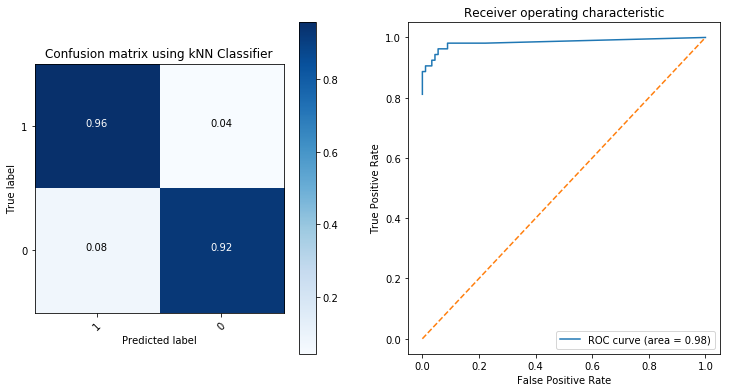

In [11]:
#Confusion Matrix
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,5))
plt.subplot(121)
clas= np.array(wdbc_cancer.diagnosis.unique())
plot_confusion_matrix(conf, classes= clas, normalize=True, title='Confusion matrix using kNN Classifier')

#Predict scores
y_score_knn = model.predict_proba(X_test_std)[:,1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.subplots_adjust(wspace=0.2)
plt.subplot(122)
plt.plot(fpr_knn, tpr_knn, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

prec_recall_results = precision_recall_fscore_support(y_test, y_pred, average='weighted')
#Append to compare different models
accuracy_all_models.append(accuracy_score(y_test, y_pred))
precision_all.append(prec_recall_results[0])
recall_all.append(prec_recall_results[1])
f_measure_all.append(prec_recall_results[2])

# SVM Classifier

In [12]:
#Set the parameters by cross-validation
params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
          {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

model = svm.SVC(class_weight= "balanced", probability=True)
grid = GridSearchCV(model, param_grid=params, cv = 10, scoring = "accuracy", n_jobs=-1)

#Learning
grid.fit(X_train_std, y_train)

#Evaluate
print (grid.best_score_)
print (grid.best_params_)

model = grid.best_estimator_
model.fit(X_train_std, y_train)
y_pred = model.predict(X_test_std)

print("Prediction Accuracy: \n",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9859154929577465
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Prediction Accuracy: 
 0.9440559440559441
             precision    recall  f1-score   support

          0       0.98      0.93      0.95        90
          1       0.89      0.96      0.93        53

avg / total       0.95      0.94      0.94       143



Normalized confusion matrix


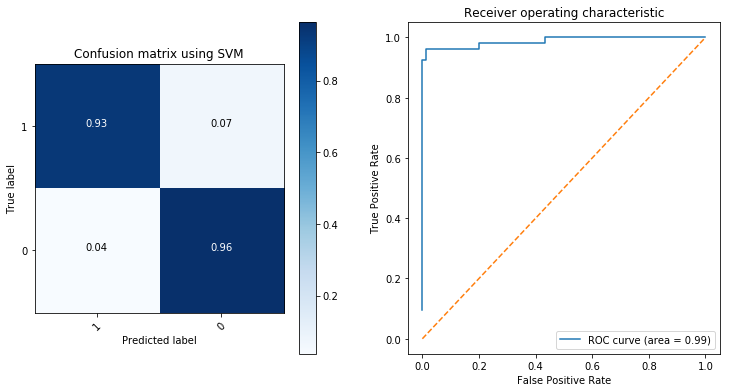

In [13]:
#Confusion Matrix
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,5))
plt.subplot(121)
clas= np.array(wdbc_cancer.diagnosis.unique())
plot_confusion_matrix(conf, classes= clas, normalize=True, title='Confusion matrix using SVM')

## Predict scores
y_score_svm = model.predict_proba(X_test_std)[:,1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.subplots_adjust(wspace=0.2)
plt.subplot(122)
plt.plot(fpr_svm, tpr_svm, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

prec_recall_results = precision_recall_fscore_support(y_test, y_pred, average='weighted')
#Append to compare different models
accuracy_all_models.append(accuracy_score(y_test, y_pred))
precision_all.append(prec_recall_results[0])
recall_all.append(prec_recall_results[1])
f_measure_all.append(prec_recall_results[2])

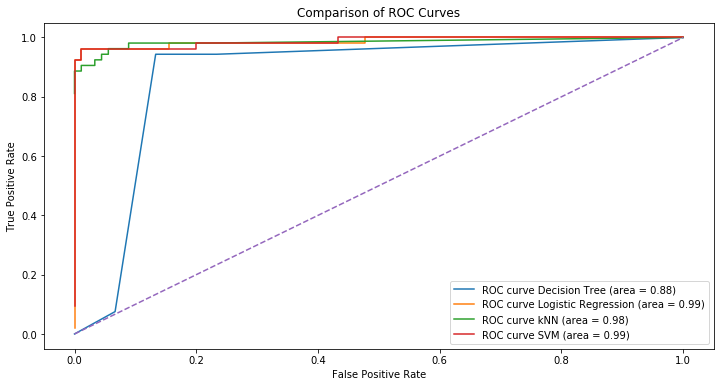

In [14]:
plt.figure(figsize = (12,6))
plt.plot(fpr_dt, tpr_dt, label='ROC curve Decision Tree (area = %0.2f)' % roc_auc_dt)
plt.plot(fpr_ll, tpr_ll, label='ROC curve Logistic Regression (area = %0.2f)' % roc_auc_ll)
plt.plot(fpr_knn, tpr_knn, label='ROC curve kNN (area = %0.2f)' % roc_auc_knn)
plt.plot(fpr_svm, tpr_svm, label='ROC curve SVM (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend(loc="lower right")
plt.show()



In [15]:
d = {'Accuracy':accuracy_all_models,
     'Precision Score': precision_all, 
     'Recall_score':recall_all, 'F Score':f_measure_all }
index = ['DecisionTree', 'Logistic Regression', 'kNN Classifier', 'SVM']

df = pd.DataFrame(d, index=index)
df

,Accuracy,F Score,Precision Score,Recall_score
DecisionTree,0.895105,0.896449,0.904955,0.895105
Logistic Regression,0.958042,0.958195,0.958741,0.958042
kNN Classifier,0.944056,0.944056,0.944056,0.944056
SVM,0.944056,0.944437,0.946350,0.944056


# Using Nested CV for Model Comparison and getting best Model

In [35]:
accuracy_all_models_nested_cv = []
std_all_models_nested_cv = []

In [36]:
def nested_cv_evaluation(classifier, parameters):
    
    # set the number of iterations to do
    NUM_TRIALS = 5
    nested_scores = np.zeros(NUM_TRIALS)
    
    for i in range(NUM_TRIALS):
    
        # Choose cross-validation techniques for the inner and outer loops,
        # independently of the dataset.
        inner_cv = KFold(n_splits=3, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    
        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=classifier, 
                           param_grid=parameters, 
                           cv=inner_cv)
        clf.fit(X_train_std, y_train)

        # Nested CV with parameter optimization
        nested_score = cross_val_score(clf, X_train_std, y_train,cv=outer_cv, scoring = "recall")
        
        # Store values for reporting
        nested_scores[i] = nested_score.mean()
         
    accuracy_all_models_nested_cv.append(nested_scores.mean())
    std_all_models_nested_cv.append(nested_scores.std())

In [37]:
#######################     SVM       ###################################
svm1 = svm.SVC(probability=True)
parameters_svm = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-5, 1e-7],
                     'C': [.001, .01, 1, 5, 10, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [.001, .01, 1, 10, 100, 1000]},
                    {'kernel':['poly'], 'C':[.001, .01, 1, 10, 100, 1000], 'degree':[1,3,5]}]

nested_cv_evaluation(svm1, parameters_svm)

In [39]:
#######################     KNN       ###################################
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
parameters_knn = dict(n_neighbors = k_range, weights = weight_options)
knn = KNeighborsClassifier()
nested_cv_evaluation(knn, parameters_knn)    

In [41]:
#######################     DT        ###################################
parameters_dt = {'max_depth': np.arange(3, 10), 'min_samples_split' : range(10,100,20)}
dt = DecisionTreeClassifier()
nested_cv_evaluation(dt, parameters_dt)

In [42]:
#######################     LR        ###################################
parameters_lr = {"C": [0.1, 1, 10, 100],"penalty" : ['l1','l2']}
lr = LogisticRegression()
nested_cv_evaluation(lr, parameters_lr)

In [43]:
accuracy_all_models_nested_cv

[0.9586438035253877,
 0.9191409531873284,
 0.8573602675716462,
 0.9633673022488866]

In [47]:
e = {'Recall_Score': accuracy_all_models_nested_cv,
     'Standard Deviation': std_all_models_nested_cv}
index = ['SVM', 'KNN', 'DecisionTree', 'Logistic Regression']

df1 = pd.DataFrame(e, index=index)
df1

,Recall_Score,Standard Deviation
SVM,0.958644,0.008472
KNN,0.919141,0.006053
DecisionTree,0.857360,0.023825
Logistic Regression,0.963367,0.004939


#### Best Model is Logistic Regression. Lets use Grid Search for Hyperparameter Tuning for Logistic Regression

In [55]:
# Set the parameters by cross-validation

params = {"C": [0.1, 1, 10, 100],
         "penalty" : ['l1','l2']}
model = LogisticRegression(random_state=1234, class_weight= "balanced")
grid = GridSearchCV(model, param_grid=params, cv=10, scoring="recall", n_jobs=-1)

#Learning
grid.fit(X_train_std, y_train)

#Evaluate
print (grid.best_score_)
print (grid.best_params_)
#print (grid.best_estimator_)

model = grid.best_estimator_
model.fit(X_train_std, y_train)
y_pred = model.predict(X_test_std)

0.9813673708920188
{'C': 0.1, 'penalty': 'l1'}


In [53]:
print("Prediction Accuracy: \n",recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Prediction Accuracy: 
 0.9622641509433962
             precision    recall  f1-score   support

          0       0.98      0.93      0.95        90
          1       0.89      0.96      0.93        53

avg / total       0.95      0.94      0.94       143



Normalized confusion matrix


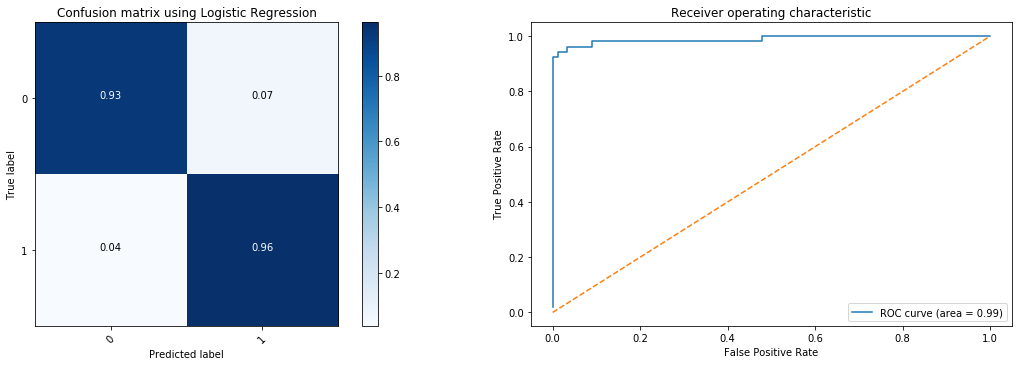

In [63]:
#Confusion Matrix
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (15,5))
plt.subplot(121)
clas= np.array([0,1])
plot_confusion_matrix(conf, classes= clas, normalize=True, title='Confusion matrix using Logistic Regression')

## Predict scores
y_score_lr = model.predict_proba(X_test_std)[:,1]
fpr_ll, tpr_ll, _ = roc_curve(y_test, y_score_lr)
roc_auc_ll = auc(fpr_ll, tpr_ll)

plt.subplots_adjust(wspace=0.2)
plt.subplot(122)
plt.plot(fpr_ll, tpr_ll, label='ROC curve (area = %0.2f)' % roc_auc_ll)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

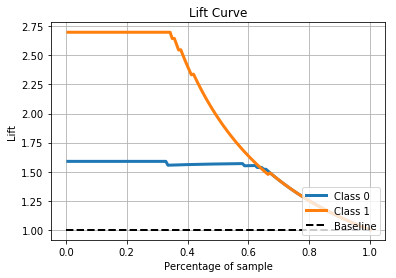

In [62]:
#Lift Plot
skplt.metrics.plot_lift_curve(y_test,model.predict_proba(X_test_std))
plt.show()